# Estimating $\pi$ with the Monte Carlo Simulation using Pyspark

**Author**: Berg Lloyd-Haig

### 1. Introduction

Monte Carlo simulations are named after the popular gambling destination in Monaco, since chance and random outcomes are central to the modeling technique, much as they are to games like roulette, dice, and slot machines.

The technique was first developed by Stanislaw Ulam, a mathematician who worked on the Manhattan Project. After the war, while recovering from brain surgery, Ulam entertained himself by playing countless games of solitaire. He became interested in plotting the outcome of each of these games in order to observe their distribution and determine the probability of winning. After he shared his idea with John Von Neumann, the two collaborated to develop the Monte Carlo simulation.

<br/>

#### 1.2. Formula to Estimate $\pi$

We can use the Monte Carlo Method to calculate an estimation of the value of $\pi$.<br/>
Consider that we already know that the formula to calculate the area of a circle ($A_o$) is:

<br/><center><font size=5>
$ A_o = \pi\cdot r^2 $
</font></center><br/>

Therefore, we can change this equation around where we can calculate $\pi$ if we already know the area of the circle ($A_o$):

<br/><center><font size=5>
$ \pi = \frac{A_o}{r^2} $
</font></center><br/>

Naturally, the value ${r^2}$ is the same formula that defines the area of a square ($A_s$) with a side length $r$:

<br/><center><font size=5>
$ \pi = \frac{A_o}{A_s} $
</font></center><br/>

Thus, the value of pi is the area of the circle (_O_) divided by the area of the square (_s_).<br/><br/>
<br/>
#### 1.3. Implenting the Monte Carlo Method

If we were then to consider a Cartesian plane where we draw a circle (_O_) with a radius (_r_) of _1_. Then next to the circle we have a square (_s_) with sides equal to the radius (_r_) of _O_.<br/><br/>

<center><font size="1"><a id="fig1">$fig.1$</a></font><br /><font size="3.5">Defining the Plane and Shapes</font></center>

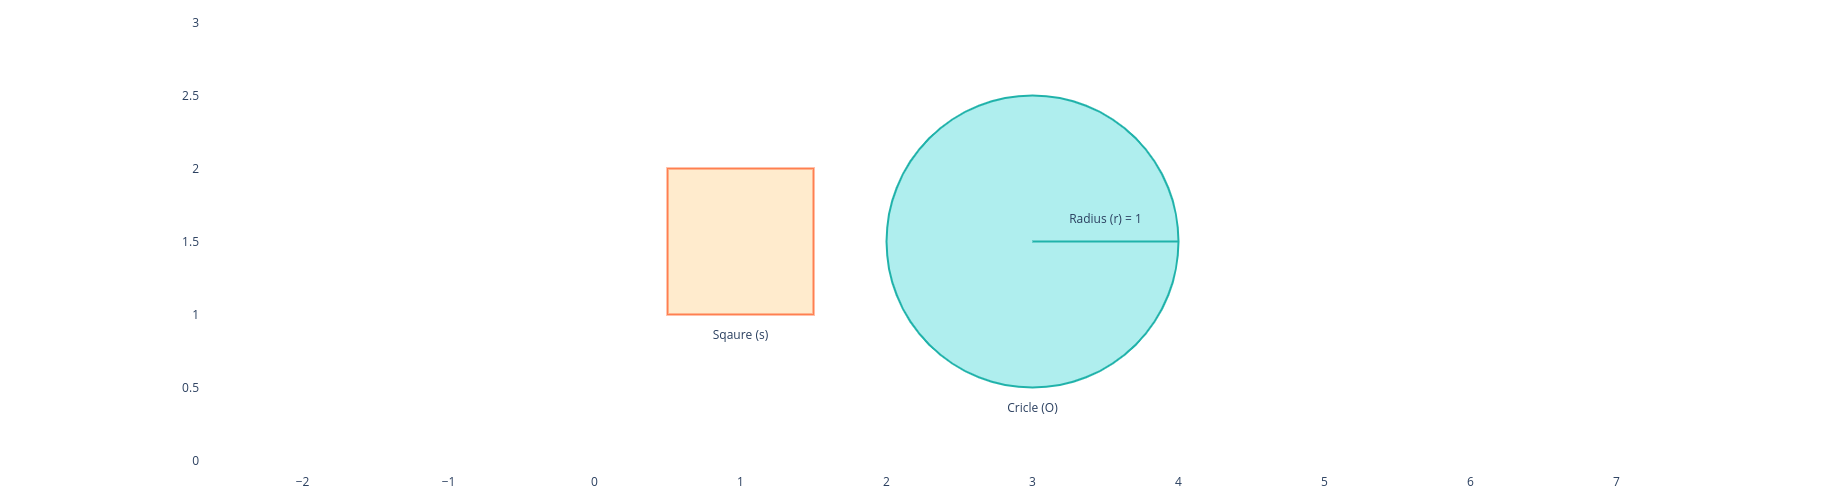

In [10]:
import plotly.graph_objects as go

fig = go.Figure()

# Add circles
fig.add_shape(type="rect",
    xref="x", yref="y",
    fillcolor="blanchedalmond",
    x0=0.5, y0=1, x1=1.5, y1=2,
    line_color="coral",
)
fig.add_shape(type="circle",
    xref="x", yref="y",
    fillcolor="PaleTurquoise",
    x0=2, y0=0.5, x1=4, y1=2.5,
    line_color="LightSeaGreen",
    layer="below",
)
fig.add_shape(type="line",
    xref="x", yref="y",
    x0=3, y0=1.5, x1=4, y1=1.5,
    line_color="LightSeaGreen",
)

# Create scatter trace of text labels
fig.add_trace(go.Scatter(
    x=[1, 3, 3.5],
    y=[0.85, 0.35, 1.65],
    text=["Sqaure (s)",
          "Cricle (O)",
         "Radius (r) = 1"],
    mode="text",
))

# Set axes properties
fig.update_xaxes(range=[0, 4.5], zeroline=False, layer="below traces", showgrid=False)
# scale anchor ensures our plot is centred and our ratios remain correct
fig.update_yaxes(range=[0, 3], zeroline=False, layer="below traces", showgrid=False, scaleanchor = "x", scaleratio=1)

# Set figure size
#fig.update_layout(template="plotly_white", width=960, height=640, margin={"r":10,"t":10,"l":100,"b":10})
fig.update_layout(template="plotly_white", height=500, margin={"r":200,"t":10,"l":200,"b":10})

##fig.update_layout()
fig.show()

Using the concept of the Monte Carlo Method, we can use the range of the plane axes (x=[0,4.5], y=[0,3]) to generate a series of random points (_x_,_y_) in the co-ordinate system as the input to our simulation. As we know that the _O_ is exactly pi times the area of _s_, we can then count the number of random points in each shape, and then divide the count of _O_ by the count of _s_ to estimate the value of pi in that simulation run.

<br/><br/>
### 2. Monte Carlo Simulation as a Spark Data Frame

We can create a data frame using Spark to contain the random points and evaluate their relative positions to the positied shapes $O$ & $s$. 

#### 2.1. Python Imports

In [11]:
import os, sys, logging, multiprocessing
import pandas as pd
from psutil import virtual_memory
from math import pi
from tqdm.notebook import tqdm

pd.set_option('display.max_colwidth', None)         # don't truncate records
pd.set_option('display.max_rows', 3001)             # don't truncate records

from IPython.core.display import display, HTML    # used to enable wide cell display

import pyspark.sql.functions as f
from pyspark.conf import SparkConf
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *

<br/>

#### 2.2. Inferring Computing Contraints

Each system will run this notebook differently, scale the driver CPU and RAM according to the local system.

In [12]:
cpu = multiprocessing.cpu_count()
mem = virtual_memory()
ram = int(mem.total / 2**30)

partitions = cpu * 2
driver_memory = int(ram * 0.65)
driver_result = int(driver_memory * 0.75)

<br/>

#### 2.3 Initialise the Pyspark Session

In [13]:
spark = (SparkSession.builder.appName("Monte Carlo Simulation")
  .config("spark.sql.shuffle.partitions", partitions)
  .config("spark.default.parallelism", cpu)
  .config("spark.driver.cores", cpu)
  .config("spark.extraListeners", "sparkmonitor.listener.JupyterSparkMonitorListener")
  .config("spark.driver.extraClassPath", "/opt/conda/lib/python3.9/site-packages/sparkmonitor/listener.jar")
  .config("spark.driver.maxResultSize", f"{driver_result}g")
  .config("spark.driver.memory", f"{driver_memory}g")
  .config("spark.ui.enabled", True)
  .enableHiveSupport()
  .getOrCreate()
)

Py4JJavaError: An error occurred while calling None.org.apache.spark.sql.SparkSession.
: java.lang.IllegalStateException: Cannot call methods on a stopped SparkContext.
This stopped SparkContext was created at:

org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.lang.reflect.Constructor.newInstance(Constructor.java:423)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
py4j.ClientServerConnection.run(ClientServerConnection.java:106)
java.lang.Thread.run(Thread.java:748)

The currently active SparkContext was created at:

(No active SparkContext.)
         
	at org.apache.spark.SparkContext.assertNotStopped(SparkContext.scala:118)
	at org.apache.spark.sql.SparkSession.<init>(SparkSession.scala:109)
	at org.apache.spark.sql.SparkSession.<init>(SparkSession.scala:104)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
	at sun.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
	at sun.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
	at java.lang.reflect.Constructor.newInstance(Constructor.java:423)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:238)
	at py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
	at py4j.commands.ConstructorCommand.execute(ConstructorCommand.java:69)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


The configuration of the Spark Context can be printed to check the applied settings.

In [5]:
sc = spark.sparkContext
sc.setLogLevel("ERROR")
print("INFO: Spark Context Configuration\n")
for k, v in sorted(sc.getConf().getAll(), key=lambda tup: tup[0]):
    print("{:<40}{}".format(f"{k}:",v))

INFO: Spark Context Configuration

spark.app.id:                           local-1629346295174
spark.app.name:                         Monte Carlo Simulation
spark.app.startTime:                    1629346294722
spark.default.parallelism:              24
spark.driver.cores:                     24
spark.driver.extraClassPath:            /opt/conda/lib/python3.9/site-packages/sparkmonitor/listener.jar
spark.driver.extraJavaOptions:          -Dio.netty.tryReflectionSetAccessible=true
spark.driver.host:                      a08663356ec8
spark.driver.maxResultSize:             15g
spark.driver.memory:                    20g
spark.driver.port:                      42129
spark.executor.extraJavaOptions:        -Dio.netty.tryReflectionSetAccessible=true
spark.executor.id:                      driver
spark.extraListeners:                   sparkmonitor.listener.JupyterSparkMonitorListener
spark.master:                           local[*]
spark.rdd.compress:                     True
spark.seriali

<br/>

#### 2.4. Monte Carlo Data Frame

The data frame will represent the series of random points in the Cartesian plane. Each row will be a randomly generated point. The coordinates of each point will consist of an x and y co-ordinate within the Cartesian plane range.

In [6]:
# plane range from zero
x_range = 4.5
y_range = 3

# shape dimensions
circle_radius = 1
circle_centre = (3, 1.5)
square_x_range = (0.5, 1.5)
square_y_range = (1, 2)

# seed 10 million rows
point_index = list(range(0, 1000**2*10))

In [7]:
df = spark.createDataFrame(list(map(lambda x: Row(point=x), point_index)))

Create a data frame with the `point_index` number of rows. Return a count of rows to test the data frame length.

In [8]:
df.count()

10000000

<br/>

#### 2.5. Generating Random points

In [ ]:
df = (df.withColumn("x", 4.5*f.rand())
      .withColumn("y", 3*f.rand()))

The `rand()` function generates random floating point numbers between 0 and 1. You can apply a factor to this random number which will scale it to the range of each axis in the Cartesian plane. As the point index is no longer required, the column can be dropped. This section can be repeated to generate points for each simulation.

<br/><font size="1"><a id="fig2">$fig.2$</a></font><br /><font size="3.5">Sample of Random Points</font>

In [ ]:
df.limit(20).toPandas().head(20)

<br/>

#### 2.6. Evaluate Point Locations

The randomly generated points in the data frame (`df`) need to be evaluated to determine the region in which they exist.

In this step, a column is added to the data frame that defines the region on the plane that the random point exists; inside the `Cricle`, inside the `Square` or `Outside`. The column value is determined by evaluating the `x` and `y` co-ordinates in their respective columns using the Pyspark `when()` function. The `when()` function evaluates a list of conditions and returns one of multiple possible result expressions. It is similar in concept to the `if`, `elif`, `else` statements in `Python`. The functions inputs are `where(condition_expression, set_value_if_true).otherwise(fallback_value)`. It is possible to chain multiple `when()` conditions together: `when(condition_1, value_1).when(condition_2, value_2)`.

1. The first `when` condition evaluates if the the point is inside the square as this is the least computationally expensive operation.
2. The second `when` condition calculates the distance of the points from the centre of the circle using Pythagoras theorem:
   <br/><br/><font size=4><center>
   $c=\sqrt{a^2 + b^2}$
   </font></center><br/><br/>
   In this case, the distance from the Circle (O)'s centre for a given random point would be:
   <br/><br/><font size=4><center>
   $d=\sqrt{({x - O_{x}})^2 + ({y - O_{y}})^2}$
   </font></center><br/><br/>
3. Otherwise, the point must be `outside` either shape.

<br/>

#### 2.7. Simulation Visualisation

Now that the selection of random points have been evaluated, they can be scatter plotted onto the original Cartesean plane with the defined shapes to validate the region calculations. First the `sample()` function is used to select a random set of rows from the data frame. The `fraction` parameter does not guarantee an exact sample size, so the limit is used on the output to return the exact desired set size. The set is returned as a Pandas data frame which makes for easy plotting with the `Plotly` visualisation library.

In [ ]:
df = df.withColumn("region",
  f.when(
    # check if the point is first inside the x and y ranges of the square
    (
      ((df['x'] > square_x_range[0]) & (df['x'] < square_x_range[1]))
        &
      ((df['y'] > square_y_range[0]) & (df['y'] < square_y_range[1])))
    , f.lit("Square")
  ).when(
    # check point distance from the circle centre using pythagoras' theorem
    f.sqrt(
      ((df['x']-circle_centre[0])**2)
        +
      ((df['y']-circle_centre[1])**2)
    )
    # if the distance from the centre of the circle is less than the radius, the point must be inside the circle region
    < circle_radius, f.lit("Circle")
  ).otherwise(
    # the point must exist outside of the shapes  
    f.lit("Outside")
  )
)

<br/><br/><font size="1"><a id="fig3">$fig.3$</a></font><br /><font size="3.5">Evaluated Points</font>

In [ ]:
pdf = df.sample(withReplacement=False, fraction=0.001).limit(10000).toPandas()

<br/><br/><center><font size="1"><a id="fig4">$fig.4$</a></font><br /><font size="3.5">Random Sample of Evaluated Points</font></center>

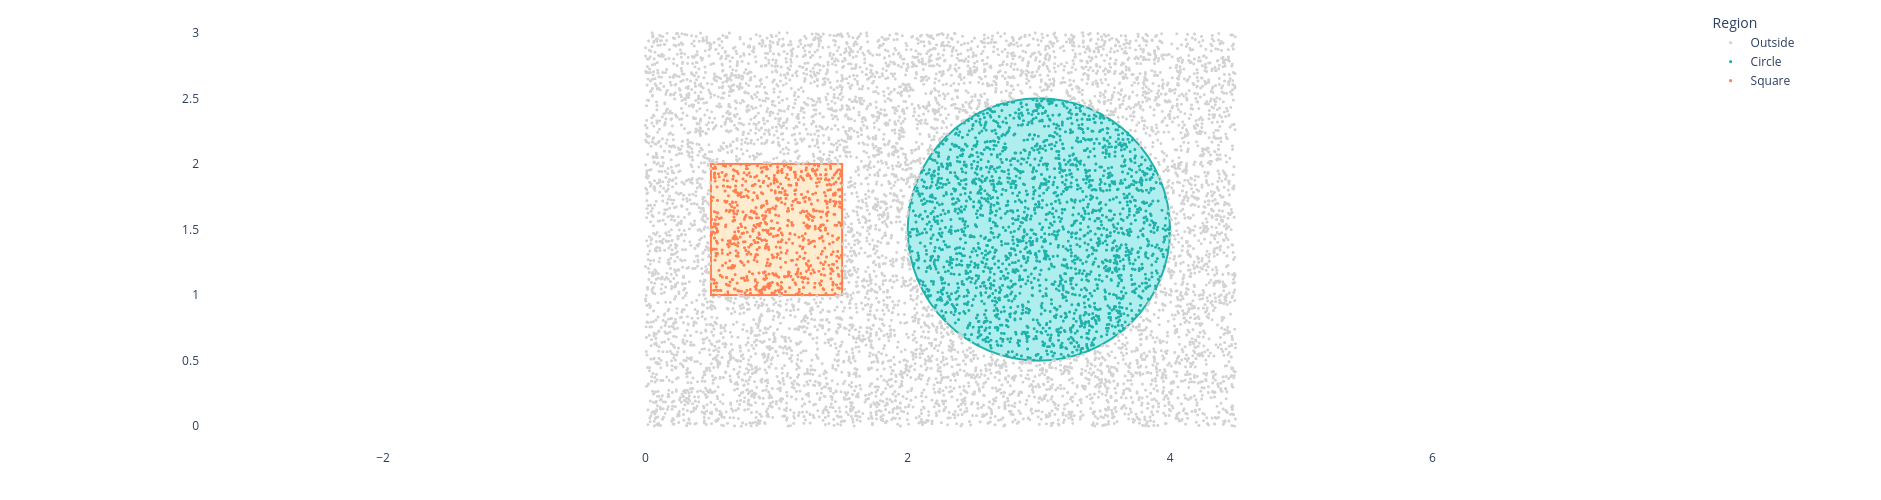

In [13]:
#import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter(pdf, x="x", y="y", color="region",
            labels={ "region": "Region",  "x": "$x\ axis$", "y": "$y\ axis$" },
            color_discrete_map={ "Outside": "lightgray", "Square": "coral", "Circle": "lightseagreen" })

fig.add_shape(type="rect", #square
    xref="x", yref="y",
    fillcolor="blanchedalmond",
    x0=0.5, y0=1, x1=1.5, y1=2,
    line_color="coral",
    layer="below",
)
fig.add_shape(type="circle",
    xref="x", yref="y",
    fillcolor="PaleTurquoise",
    x0=2, y0=0.5, x1=4, y1=2.5,
    line_color="LightSeaGreen",
    layer="below",
)

# set axes properties
fig.update_xaxes(range=[0, 4.5], zeroline=False, layer="below traces", showgrid=False)
fig.update_yaxes(range=[0, 3], zeroline=False, layer="below traces", showgrid=False, scaleanchor = "x", scaleratio=1)

# set figure size
fig.update_layout(template="plotly_white", height=500, margin={"r":200,"t":10,"l":200,"b":10})
fig.update_traces(marker_size=3)
fig.show()

<br/>

#### 2.8. Calculating the Results

After the region of each random point have been identified, the count of each region can be performed using `groupBy()`.

In [14]:
results = df.select("region").groupBy("region").count()

In [15]:
results.toPandas().head()

region    count
0  Outside  6931158
1   Circle  2328541
2   Square   740301

The final step is to divide the count of points inside the `Circle` by the points inside the `Square`.

In [16]:
estimate = results.where(results['region'] == 'Circle').collect()[0]['count'] / results.where(results['region'] == 'Square').collect()[0]['count']
error = pi-estimate
from IPython.display import Markdown as md
md(f"The Monte Carlo simulation resulted in the estimation of $\pi$ to be **{estimate}** with an error of {error:.6f} or **{error/pi:.6f}%**")

The Monte Carlo simulation resulted in the estimation of $\pi$ to be **3.1453976152943195** with an error of -0.003805 or **-0.001211%**

### 3. Stop the Spark Session

In [17]:
spark.stop()